
# Explanation of the task:

This is the classic Emotion Recognition Classification task. Given a conversation, involving 2 or more parties, for each message/utterance, we want to predict an emotion related to it.


Consider the example:

**Person A**: "Hello! I am very happy" (happiness)

**Person B**: "Why? I am very angry"   (anger)

## First model idea:
- inputs: sequence of utterances, sequence of emotions.
- For each: Linear Layers
- Fusion model

- Loss: cross-entropy



# Preprocessing:

Consider the each conversation as just a sequence of words:
$$
[[utt, utt, \cdots], \cdots ] \longrightarrow [[word, word , \cdots], \cdots]
$$

In here, we add a separator token "sep". It will serve to indicate when a utteration is over, and another one starts. We also add a padding token at the end to ensure that all inputs have same dimention.


In [1]:
! pip install nltk
! pip install torch
! pip install pandas
! pip install gensim
! pip install datasets
! pip install matplotlib
! pip install tqdm
! pip install torchinfo
! pip install requests json
# eventually include tensorboard

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 17.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 15.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
ERROR: Could not find a version that satisfies the requirement json (from versions: none)
ERROR: No matching distribution found for json


In [2]:
import torch
import os
import matplotlib.pyplot as plt
import gensim
import json
import requests
from nltk.tokenize import TweetTokenizer

from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader, random_split
from collections import Counter

import pandas as pd
import numpy as np

In [3]:
! wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
! unzip wiki-news-300d-1M.vec.zip
! rm wiki-news-300d-1M.vec.zip

--2025-01-21 13:58:49--  https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 108.157.254.15, 108.157.254.102, 108.157.254.124, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|108.157.254.15|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 681808098 (650M) [application/zip]
Saving to: ‘wiki-news-300d-1M.vec.zip’

wiki-news-300d-1M.v 100%[===================>] 650.22M   217MB/s    in 3.0s    

2025-01-21 13:58:53 (217 MB/s) - ‘wiki-news-300d-1M.vec.zip’ saved [681808098/681808098]

Archive:  wiki-news-300d-1M.vec.zip
  inflating: wiki-news-300d-1M.vec   


In [4]:
## taken from template
encoder_model = gensim.models.KeyedVectors.load_word2vec_format("wiki-news-300d-1M.vec", binary = False)

In [5]:
## We create the embeddings and find the vocab
import copy
unk_token, pad_token, sep_token = '<unk>', '<pad>','<sep>'
embedding_vectors = torch.from_numpy(encoder_model.vectors)
pretrained_vocab = copy.deepcopy(encoder_model.index_to_key)
pretrained_vocab[:0] = [pad_token, unk_token,sep_token]

stoi = {word: i for i, word in enumerate(pretrained_vocab)}
itos = {i: word for i, word in enumerate(pretrained_vocab)}

pretrained_embeddings = torch.cat((torch.zeros(1,embedding_vectors.shape[1]),embedding_vectors))
pretrained_embeddings = torch.cat((torch.ones(1,embedding_vectors.shape[1]),embedding_vectors))
pretrained_embeddings = torch.cat((-torch.ones(1,embedding_vectors.shape[1]),embedding_vectors))

In [6]:
from nltk.tokenize import TweetTokenizer
from tqdm.notebook import tqdm

max_size = 50
## By using the template that was shared, we can process the inputs in a very similar way
tok = TweetTokenizer()
def tokenize_text_extend_emotions(text,emotion,stoi): ## utteration : string -> list of tokenized words : [int]
  text = tok.tokenize(text)
  text = [stoi[word] if word in stoi else stoi['<unk>'] for word in text]
  return text, [emotion]*len(text)

def concat_utt(dialog, emotions, stoi, max_size=max_size + 1): ## list of utterations : [string] -> list of list of tokenized words : [int]
  tokenized_and_extended = [tokenize_text_extend_emotions(t,e,stoi) for t,e in zip(dialog,emotions)]
  dialog = [i[0] for i in tokenized_and_extended]
  emotions = [i[1] for i in tokenized_and_extended]
  dialog_flat = []
  emotions_extended = []
  for i in range(len(dialog) - 1):
    dialog[i].append(stoi["<sep>"])
    emotions[i].append(emotions[i][0])
  for i in range(len(dialog)):
    dialog_flat.extend(dialog[i])
    emotions_extended.extend(emotions[i])
  if len(dialog_flat) > max_size: ## Must cut
    dialog_flat = dialog_flat[:max_size]
    emotions_extended = emotions_extended[:max_size]
  else: ## Must add padding
    dialog_flat += [stoi["<pad>"]] * (max_size - len(dialog_flat))
    emotions_extended += [0] * (max_size - len(emotions_extended))
  return dialog_flat,emotions_extended

def adjust_emotion_labels(Y): ## Necessary, because we will use 0 as padding for both the text and emotions.
  for i in range(len(Y)):
    for j in range(len(Y[i])):
      Y[i][j] = Y[i][j] + 1
  return Y

def preprocess_data(X,Y): ## list of lists of utterations : [[string]] -> list of lists of tokenized words : [[int]]
  X_processed = []
  Y_processed = []
  Y = adjust_emotion_labels(Y) ## sums 1 to all emotions (<pad_token> = 0)
  for i in tqdm(range(len(X))):
    X_processed.append(concat_utt(X[i],Y[i],stoi)[0])
    Y_processed.append(concat_utt(X[i],Y[i],stoi)[1])
  return X_processed, Y_processed

def get_target(X,Y): ## generates the target values and input values
  text_input = [i[:-1] for i in X]
  text_target = [i[1:] for i in X]
  emotion_input = [i[:-1] for i in Y]
  emotion_target = [i[1:] for i in Y]
  return text_input, text_target, emotion_input, emotion_target


## Check the following example:
dialog_example = ["hello, I am a I robot!","I am greek"]
emotions_example = [1,2] ## random emotions...

flatten_dialog, flatten_emotions = concat_utt(dialog_example,emotions_example,stoi)
print(f"{dialog_example} becomes {flatten_dialog}")
print(f"{emotions_example} becomes {flatten_emotions}")


['hello, I am a I robot!', 'I am greek'] becomes [13172, 3, 31, 784, 10, 31, 6872, 80, 2, 31, 784, 22505, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[1, 2] becomes [1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


## DataLoader not implemented yet:

In [7]:
## Modify this after changing the preprocessing.
class DailyDialogDataset(Dataset):
  def __init__(self, texts, emotions,target_texts,target_emotions):
  # Dataset object for Daily Dialog dataset
    self.texts = texts                     ## tokenized text
    self.emotions = emotions               ## tokenized emotions
    self.target_texts = target_texts       ## target text for loss computation
    self.target_emotions = target_emotions ## target emotions for loss computation

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    item = {
                'texts': np.array(self.texts[idx]),
             'emotions': np.array(self.emotions[idx]),
         'target_texts': np.array(self.target_texts[idx]),
      'target_emotions': np.array(self.target_emotions[idx])
    }
    return item
class MeldDataset(Dataset):
  def __init__(self, texts, emotions,target_texts,target_emotions):
  # Dataset object for MELD dataset
    self.texts = texts                     ## tokenized text
    self.emotions = emotions               ## tokenized emotions
    self.target_texts = target_texts       ## target text for loss computation
    self.target_emotions = target_emotions ## target emotions for loss computation

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    item = {
                'texts': np.array(self.texts[idx]),
             'emotions': np.array(self.emotions[idx]),
         'target_texts': np.array(self.target_texts[idx]),
      'target_emotions': np.array(self.target_emotions[idx])
    }
    return item
class EmorynlpDataset(Dataset):
  def __init__(self, texts, emotions,target_texts,target_emotions):
    # Dataset object for EmoryNLP dataset
    self.texts = texts                     ## tokenized text
    self.emotions = emotions               ## tokenized emotions
    self.target_texts = target_texts       ## target text for loss computation
    self.target_emotions = target_emotions ## target emotions for loss computation

  def __len__(self):
    return len(self.texts)

  def __getitem__(self, idx):
    item = {
                 'texts': np.array(self.texts[idx]),
              'emotions': np.array(self.emotions[idx]),
          'target_texts': np.array(self.target_texts[idx]),
      'target_emotions' : np.array(self.target_emotions[idx])
    }
    return item


Here we will extract the data and process it:

In [8]:
! wget https://raw.githubusercontent.com/declare-lab/MELD/refs/heads/master/data/MELD/dev_sent_emo.csv
! wget https://raw.githubusercontent.com/declare-lab/MELD/refs/heads/master/data/MELD/test_sent_emo.csv
! wget https://raw.githubusercontent.com/declare-lab/MELD/refs/heads/master/data/MELD/train_sent_emo.csv

--2025-01-21 14:03:02--  https://raw.githubusercontent.com/declare-lab/MELD/refs/heads/master/data/MELD/dev_sent_emo.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 121640 (119K) [text/plain]
Saving to: ‘dev_sent_emo.csv’

dev_sent_emo.csv    100%[===================>] 118.79K  --.-KB/s    in 0.002s  

2025-01-21 14:03:03 (60.7 MB/s) - ‘dev_sent_emo.csv’ saved [121640/121640]

--2025-01-21 14:03:03--  https://raw.githubusercontent.com/declare-lab/MELD/refs/heads/master/data/MELD/test_sent_emo.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response.

In [10]:
data_dd = load_dataset('daily_dialog') ## daily conversations
data_meld_train = pd.read_csv('train_sent_emo.csv').drop(columns=['Sr No.','Speaker','Sentiment','Season','Episode','StartTime','EndTime'])
data_meld_val = pd.read_csv('dev_sent_emo.csv').drop(columns=['Sr No.','Speaker','Sentiment','Season','Episode','StartTime','EndTime'])
data_meld_test = pd.read_csv('test_sent_emo.csv').drop(columns=['Sr No.','Speaker','Sentiment','Season','Episode','StartTime','EndTime'])

## For Daily Dialog:
X_train_dd = data_dd['train']['dialog']
Y_train_dd = data_dd['train']['emotion']
X_test_dd = data_dd['test']['dialog']
Y_test_dd = data_dd['test']['emotion']
X_val_dd = data_dd['validation']['dialog']
Y_val_dd = data_dd['validation']['emotion']

## For MELD
def change_Y(Y,lookup=None):
  lookup = {} if lookup is None else lookup
  k = 0
  for i in range(len(Y)):
    for j in range(len(Y[i])):
      if Y[i][j] not in lookup:
        lookup[Y[i][j]] = k
        Y[i][j] = k
        k += 1
      else:
        Y[i][j] = lookup[Y[i][j]]
  return Y, lookup


def parse_meld(df,lookup = None):
  X, Y = {}, {}
  for _, row in df.iterrows():
    dialog_id = row['Dialogue_ID']
    if dialog_id not in X:
      X[dialog_id] = []
      Y[dialog_id] = []
    X[dialog_id].append(row['Utterance'])
    Y[dialog_id].append(row['Emotion'])
  X = list(X.values())
  Y = list(Y.values())
  Y,lookup = change_Y(Y,lookup)
  return X, Y, lookup

X_train_meld, Y_train_meld, lookup_meld = parse_meld(data_meld_train)
X_test_meld, Y_test_meld, _ = parse_meld(data_meld_test,lookup_meld)
X_val_meld, Y_val_meld, _ = parse_meld(data_meld_val,lookup_meld)


## For EmoryNLP:
def parse_seasons(seasons): ## annoying parsing
  X = []
  Y = []
  for i in seasons:
    for episode in seasons[i]['episodes']:
      for scene in episode['scenes']:
        try:
          dialog = []
          emotion = []
          for utterance in scene['utterances']:
            if utterance['transcript'] != '':
              dialog.append(utterance['transcript'])
              emotion.append(utterance['emotion'][0])
          X.append(dialog)
          Y.append(emotion)
        except:
          continue
    Y,lookup = change_Y(Y)
    return X, Y, lookup

def parse_emory(): ## getting from the web
  seasons = {}
  for i in range(1,11):
    s_id = '0' + str(i) if i < 10 else str(i)
    json_file = f'https://raw.githubusercontent.com/emorynlp/character-mining/master/json/friends_season_{s_id}.json'
    r = requests.get(json_file)
    season = json.loads(r.text)
    seasons[i] = season
  return parse_seasons(seasons)

X_emory, Y_emory, lookup_emory = parse_emory()


                                              Utterance   Emotion  \
0     also I was the point person on my company’s tr...   neutral   
1                      You must’ve had your hands full.   neutral   
2                               That I did. That I did.   neutral   
3         So let’s talk a little bit about your duties.   neutral   
4                                My duties?  All right.  surprise   
...                                                 ...       ...   
9984                                         You or me?   neutral   
9985  I got it. Uh, Joey, women don't have Adam's ap...   neutral   
9986               You guys are messing with me, right?  surprise   
9987                                              Yeah.   neutral   
9988  That was a good one. For a second there, I was...       joy   

      Dialogue_ID  Utterance_ID  
0               0             0  
1               0             1  
2               0             2  
3               0             3  
4

In [11]:
# For Daily Dialog
X_train_dd, Y_train_dd = preprocess_data(X_train_dd,Y_train_dd)
X_train_dd,X_train_target_dd, Y_train_dd, Y_train_target_dd = get_target(X_train_dd,Y_train_dd)
X_test_dd, Y_test_dd = preprocess_data(X_test_dd,Y_test_dd)
X_test_dd,X_test_target_dd, Y_test_dd, Y_test_target_dd = get_target(X_test_dd,Y_test_dd)
X_val_dd, Y_val_dd = preprocess_data(X_val_dd,Y_val_dd)
X_val_dd, X_val_target_dd, Y_val_dd, Y_val_target_dd = get_target(X_val_dd,Y_val_dd)

# For MELD
X_train_meld, Y_train_meld = preprocess_data(X_train_meld,Y_train_meld)
X_train_meld,X_train_target_meld, Y_train_meld, Y_train_target_meld = get_target(X_train_meld,Y_train_meld)
X_test_meld, Y_test_meld = preprocess_data(X_test_meld,Y_test_meld)
X_test_meld,X_test_target_meld, Y_test_meld, Y_test_target_meld = get_target(X_test_meld,Y_test_meld)
X_val_meld, Y_val_meld = preprocess_data(X_val_meld,Y_val_meld)
X_val_meld, X_val_target_meld, Y_val_meld, Y_val_target_meld = get_target(X_val_meld,Y_val_meld)

## For EmoryNLP:
X_emory, Y_emory = preprocess_data(X_emory,Y_emory)
X_emory,X_target_emory, Y_emory, Y_target_emory = get_target(X_emory,Y_emory)

## Just checking if nothing wrong happened
"""
for d, e in zip(X_train,Y_train):
  assert(len(d) == len(e))
for d, e in zip(X_test,Y_test):
  assert(len(d) == len(e))
for d, e in zip(X_val,Y_val):
  assert(len(d) == len(e))
"""

  0%|          | 0/11118 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1038 [00:00<?, ?it/s]

  0%|          | 0/280 [00:00<?, ?it/s]

  0%|          | 0/114 [00:00<?, ?it/s]

  0%|          | 0/218 [00:00<?, ?it/s]

'\nfor d, e in zip(X_train,Y_train):\n  assert(len(d) == len(e))\nfor d, e in zip(X_test,Y_test):\n  assert(len(d) == len(e))\nfor d, e in zip(X_val,Y_val):\n  assert(len(d) == len(e))\n'

In [12]:
batch_size = 5 ## try with other values. 5 Might be too little!

train_data_dd = DailyDialogDataset(X_train_dd,Y_train_dd,X_train_target_dd,Y_train_target_dd)
test_data_dd = DailyDialogDataset(X_test_target_dd,Y_test_target_dd,X_test_target_dd,Y_test_target_dd)
val_data_dd = DailyDialogDataset(X_val_target_dd,Y_val_target_dd,X_val_target_dd,Y_val_target_dd)

train_data_meld = MeldDataset(X_train_meld,Y_train_meld,X_train_target_meld,Y_train_target_meld)
test_data_meld = MeldDataset(X_test_meld,Y_test_meld,X_test_target_meld,Y_test_target_meld)
val_data_meld = MeldDataset(X_val_meld,Y_val_meld,X_val_target_meld,Y_val_target_meld)

data_emory = EmorynlpDataset(X_emory,Y_emory,X_target_emory,Y_target_emory)
train_data_emory, test_data_emory, val_data_emory = random_split(data_emory,[118,50,50]) ## len(data_emory) = 218 = 118 + 50 + 50

train_loader_dd = DataLoader(train_data_dd, batch_size=batch_size,shuffle = True,)
test_loader_dd = DataLoader(test_data_dd, batch_size=batch_size,shuffle = True)
val_loader_dd = DataLoader(val_data_dd, batch_size=batch_size, shuffle = True)

train_loader_meld = DataLoader(train_data_meld, batch_size=batch_size,shuffle = True,)
test_loader_meld = DataLoader(test_data_meld, batch_size=batch_size,shuffle = True)
val_loader_meld = DataLoader(val_data_meld, batch_size=batch_size, shuffle = True)

train_loader_emory = DataLoader(train_data_emory, batch_size=batch_size,shuffle = True)
test_loader_emory = DataLoader(test_data_emory, batch_size=batch_size,shuffle = True)
val_loader_emory = DataLoader(val_data_emory, batch_size=batch_size, shuffle = True)

## Example:
train_data_emory[2] ## note that padding = 0

{'texts': array([  174,  1446,    60,  4136,     5,     2,   309,    79,   347,
            4,   463,     5,     2,  1137,    56, 14211,    40,     2,
         6816,     5,    23,  2772,   347,     4,    26,  4207,    26,
           97,     5,   174,    63,   259,    51,    26,  2519,    26,
            6,    51,    26,  1911,    26,     5,     2,   309,   165,
           56,    25,  1289,     8,  5776]),
 'emotions': array([3, 3, 3, 3, 3, 3, 6, 6, 6, 6, 6, 6, 6, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 2,
        2, 2, 2, 2, 2, 2]),
 'target_texts': array([ 1446,    60,  4136,     5,     2,   309,    79,   347,     4,
          463,     5,     2,  1137,    56, 14211,    40,     2,  6816,
            5,    23,  2772,   347,     4,    26,  4207,    26,    97,
            5,   174,    63,   259,    51,    26,  2519,    26,     6,
           51,    26,  1911,    26,     5,     2,   309,   165,    56,
           25,  1289,     8,  57

# The model:
## archtecture
- 2 input channels: word encoding, emotion encoding
- dinamically updated weights: $w_1, w_2 = w1 + w2, w1$ (Not implemented yet)
### For each channel:
   - 3 sequential Linear layers
- fusion linear layer through concatenation
- 2 output channels which contain a linear layer each





In [13]:
import torch.nn as nn
import torch.nn.functional as F
class SimpleModel(nn.Module):
  def __init__(self, emo_dim, n_emotion, n_vocab):
    super(SimpleModel,self).__init__()
    ## word_dim = 300

    self.embedding_layer_text = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=True)
    self.embedding_layer_emotion = nn.Embedding(n_emotion, emo_dim)
    ## Channel for utterances/words:
    self.Linear_utt1 = nn.Linear(300,80)
    self.Linear_utt2 = nn.Linear(80,80)
    self.Linear_utt3 = nn.Linear(80,80)

    # self.Linear_utt3.requires_grad = False

    ## Channel for emotions:
    self.Linear_emo1 = nn.Linear(emo_dim,80)
    self.Linear_emo2 = nn.Linear(80,80)
    self.Linear_emo3 = nn.Linear(80,80)
    # self.Linear_emo3.requires_grad = False

    ## fusion by concatenation and Linear layer:
    self.Linear_fus = nn.Linear(160,300)

    ## We concatenate and do linear again (2 different concatenations)
    self.Linear_utt_final1 = nn.Linear(380, 180)
    self.Linear_utt_final2 = nn.Linear(180, 90)
    self.Linear_utt_final3 = nn.Linear(90, 15)
    self.Linear_utt_final = nn.Linear(15, n_vocab)


    self.Linear_emo_final = nn.Linear(380, n_emotion)

    self.softmax = nn.Softmax(dim=0)



  def forward(self, text, emotion):
    ## first input channel:
    #mask_text = (emb_text != 0).unsqueeze(-1).float()       ## not considered by gradient!
    #mask_emotion = (emb_emotion != 0).unsqueeze(-1).float() ## not considered by gradient!

    #x = (emb_text * mask_text).int()
    #y = (emb_emotion * mask_emotion).int()
    with torch.no_grad():
      text = self.embedding_layer_text(text)
    text = self.Linear_utt1(text)
    text = self.Linear_utt2(text)
    text = self.Linear_utt3(text)

    emotion = self.embedding_layer_emotion(emotion)
    emotion = self.Linear_emo1(emotion)
    emotion = self.Linear_emo2(emotion)
    emotion = self.Linear_emo3(emotion)

    z = torch.cat((text,emotion),-1)
    z = self.Linear_fus(z)
    text = torch.cat((z,text),-1)
    text = self.Linear_utt_final1(text)
    text = self.Linear_utt_final2(text)
    text = self.Linear_utt_final3(text)
    text = self.Linear_utt_final(text)
    text = self.softmax(text)
    emotion = torch.cat((z,emotion),-1)
    emotion = self.Linear_emo_final(emotion)
    emotion = self.softmax(emotion)

    return text, emotion
    #return emotion


In [14]:
import torch.optim as optim
from tqdm.notebook import tqdm
def activate_gpu(force_cpu=False): # check if gpu available ; code taken from template
    device = "cpu"
    if not force_cpu:
        if torch.cuda.is_available(): # for both Nvidia and AMD GPUs
            device = 'cuda'
            print('DEVICE = ', torch.cuda.get_device_name(0))
        elif torch.backends.mps.is_available(): # for mac ARM chipset
            device = 'mps'
            print('DEVICE = ', "mps" )
        else: # for cpu only
            device = 'cpu'
            print('DEVICE = ', 'CPU', "blue")
    return device

## normal train function
def train(model, train_loader, epochs, device):
  optimizer = optim.Adam(model.parameters())
  loss_fn = nn.CrossEntropyLoss()
  model.train()
  model = model.to(device)
  loss = 0
  loss_to_plot = []
  for epoch in range(epochs):
    losses = []
    print(f"Epoch {epoch+1}/{epochs}")
    for it, batch in tqdm(enumerate(train_loader),total = train_loader.__len__()):

      batch = {'texts': batch['texts'].to(device),
               'emotions': batch['emotions'].to(device),
               'target_texts': batch['target_texts'].view(-1).to(device), ## reshape is necessary to compare predictions
               'target_emotions': batch['target_emotions'].view(-1).to(device)}
      optimizer.zero_grad()
      pt, pe = model.forward(batch['texts'],batch['emotions'])
      #pe = model.forward(batch['texts'],batch['emotions'])

      ## reshaping so we can compute loss
      pt = pt.view(-1,len(stoi))
      pe = pe.view(-1,8)

      ## loss(pe) + loss(pt) [slow + RAM issue - cannot do it on cpu] vs. loss(pe) [extremely faster]
      loss = loss_fn(pe,batch['target_emotions']) + loss_fn(pt, batch['target_texts'])
      loss.backward()
      optimizer.step()

      ## it will help us with the plots:
      losses.append(loss.item())
    loss_to_append = sum(losses)/len(losses)
    loss_to_plot.append(loss_to_append)
    print(f"loss: ",loss_to_append)

  return loss_to_plot


In [32]:
from torchinfo import summary

## Setting some hyper parameters:
device = activate_gpu()
emotion_dim = 30
n_emotions = 8
n_words = len(stoi)

model = SimpleModel(emotion_dim,n_emotions,n_words)
print(device)
print(summary(model))

DEVICE =  Tesla T4
cuda
Layer (type:depth-idx)                   Param #
SimpleModel                              --
├─Embedding: 1-1                         (299,998,500)
├─Embedding: 1-2                         240
├─Linear: 1-3                            24,080
├─Linear: 1-4                            6,480
├─Linear: 1-5                            6,480
├─Linear: 1-6                            2,480
├─Linear: 1-7                            6,480
├─Linear: 1-8                            6,480
├─Linear: 1-9                            48,300
├─Linear: 1-10                           68,580
├─Linear: 1-11                           16,290
├─Linear: 1-12                           1,365
├─Linear: 1-13                           15,999,952
├─Linear: 1-14                           3,048
├─Softmax: 1-15                          --
Total params: 316,188,755
Trainable params: 16,190,255
Non-trainable params: 299,998,500


Epoch 1/15


  0%|          | 0/24 [00:00<?, ?it/s]

loss:  15.657075603803
Epoch 2/15


  0%|          | 0/24 [00:00<?, ?it/s]

loss:  15.4916299978892
Epoch 3/15


  0%|          | 0/24 [00:00<?, ?it/s]

loss:  15.414209206899008
Epoch 4/15


  0%|          | 0/24 [00:00<?, ?it/s]

loss:  15.359379887580872
Epoch 5/15


  0%|          | 0/24 [00:00<?, ?it/s]

loss:  15.378479162851969
Epoch 6/15


  0%|          | 0/24 [00:00<?, ?it/s]

loss:  15.352802475293478
Epoch 7/15


  0%|          | 0/24 [00:00<?, ?it/s]

loss:  15.320460081100464
Epoch 8/15


  0%|          | 0/24 [00:00<?, ?it/s]

loss:  15.308952490488688
Epoch 9/15


  0%|          | 0/24 [00:00<?, ?it/s]

loss:  15.275932113329569
Epoch 10/15


  0%|          | 0/24 [00:00<?, ?it/s]

loss:  15.264060537020365
Epoch 11/15


  0%|          | 0/24 [00:00<?, ?it/s]

loss:  15.256350676218668
Epoch 12/15


  0%|          | 0/24 [00:00<?, ?it/s]

loss:  15.262659072875977
Epoch 13/15


  0%|          | 0/24 [00:00<?, ?it/s]

loss:  15.276698430379232
Epoch 14/15


  0%|          | 0/24 [00:00<?, ?it/s]

loss:  15.266147494316101
Epoch 15/15


  0%|          | 0/24 [00:00<?, ?it/s]

loss:  15.260714888572693


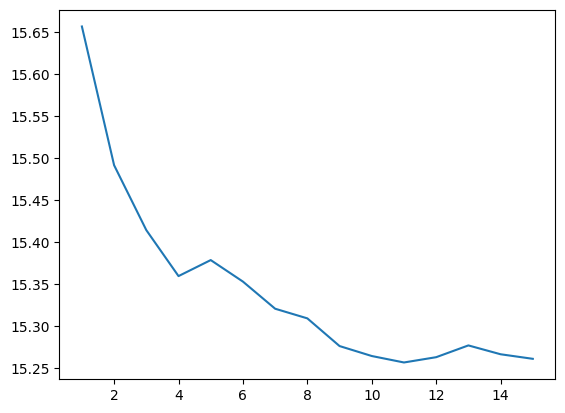

In [33]:
epochs = 15
## Do later : increase batch size!
## training in the cpu with the loss for the tokens excrutiatingly slow
## It becomes faster when we train with only the loss for the emotions
losses = train(model, train_loader_emory, epochs, device)

## Somewhat of a problem: Since we have padding for the emotions also,
## it quite affects the predictions...
plt.plot(np.arange(1,epochs+1),losses)

# Descrition of the issues faced:

It is not trivial of how to deal with the gradient flow in this case. Maybe by fixing the 2 matrix it would go better. Or just train the matrix with fixed weight. And update the weight not in the forward pass. but in the prediction. this way we can cache the weight and everytime we restart, we will be ok.

I believe that, the issue of this approach specifically is updating directly the weights, and not, a hidden state, for instance.

# Problem with Daily Dialog:
By plotting the frequency of each emotion, we notice that the dataset is truly not diversified. It has essentially only 2 emotions. This is not ideal, because the models will most likely overfit into predicting those 2 emotions...

In [34]:
def compute_test_loss(model,loss_fn,data_loader,device):
  model.eval()
  losses = []
  accs = []
  preds = [] ## predictions will be here
  prec = 0
  trues = [] ## true values will be here
  for it,batch in tqdm(enumerate(data_loader),total=data_loader.__len__()):
    batch = {'texts' : batch['texts'].to(device),
             'emotions': batch['emotions'].to(device),
             'target_texts': batch['target_texts'].view(-1).to(device),
             'target_emotions': batch['target_emotions'].view(-1).to(device)}

    #pe   = model.forward(batch['texts'],batch['emotions'])
    _ , pe   = model.forward(batch['texts'],batch['emotions'])

    ## reshape so we can compute loss
    pe = pe.view(-1,8)

    ## For this computation, the token loss doesn't matter much...
    loss = loss_fn(pe,batch['target_emotions'])

    ## compute corrects:
    index_pred = torch.argmax(pe,1)
    correct = (batch['target_emotions'].flatten() == index_pred.flatten()).float().sum()
    acc = correct/len(index_pred.flatten())
    accs.append(acc.item())

    ## for plotting the loss:
    losses.append(loss.item())

    ## Saving true values and predictions:
    trues.extend(batch['target_emotions'].flatten().tolist())
    preds.extend(index_pred.tolist())

  print("average loss: ", sum(losses)/len(losses))
  print("average acc: ", sum(accs)/len(accs))
  return trues, preds

In [37]:
trues, preds = compute_test_loss(model,nn.CrossEntropyLoss(),val_loader_emory,device)

  0%|          | 0/10 [00:00<?, ?it/s]

average loss:  1.6595219731330872
average acc:  0.7716000378131866


In [40]:
from sklearn.metrics import classification_report, confusion_matrix
names = [f'{i}' for i in range(0,8)]
print(classification_report(np.array(trues).flatten(), np.array(preds).flatten(), target_names=names))
print(confusion_matrix(trues,preds))

## to visually see how it compares:
print(trues[:200])
print(preds[:200])

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         1
           1       0.91      0.76      0.83       366
           2       0.99      0.64      0.78       928
           3       0.90      0.90      0.90       417
           4       0.70      0.83      0.76       355
           5       0.61      0.88      0.72       165
           6       0.45      0.91      0.61       110
           7       0.52      0.89      0.66       158

    accuracy                           0.77      2500
   macro avg       0.64      0.73      0.66      2500
weighted avg       0.84      0.77      0.78      2500

[[  0   0   1   0   0   0   0   0]
 [  2 279   3  13  22  15  29   3]
 [ 15  15 594  17  78  46  54 109]
 [  0   1   0 374   7   7  23   5]
 [  9   7   3   2 296  20   9   9]
 [  0   0   1   1  11 146   4   2]
 [  0   3   0   0   4   2 100   1]
 [  0   1   1   9   4   2   1 140]]
[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7

In [ ]:
## finish later:

def eval_sentence(model, sentence, encoded_sentence, emotions, device):
  model.eval()
  for i in range(len(sentence) - 1):
    pe, _ = model.forward(encoded_sentence[i].to(device),emotions[i].to(device))
    t = torch.max(pe,1)
    print(f"word:{sentence[i+1]}; predicted_emotion: {t} ; target_emotion: {emotions[i+1]}")

# eval_sentence(model,sentence,encod,emot,device)